### Installing PyTorch

To install PyTorch in a terminal, do this:

First create a Conda environment using:

```conda create -n env_pytorch python=3.6```

Activate the environment using:

```conda activate env_pytorch```

Now install PyTorch using pip:

```pip install torchvision ```

Note: This will install both torch and torchvision.

Now launch this Jupyter notebook from that terminal shell and run:

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### A regression tutorial

This following link is EXCELLENT. Read it in FULL. My code below summarizes its results. You will not understand what is going on below if you do not read the article.

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#dc96

Most tutorials start with some nice and pretty image classification problem to illustrate how to use PyTorch. It may seem cool, but I believe it distracts you from the main goal: how PyTorch works?
For this reason, in this tutorial, I will stick with a simple and familiar problem: a linear regression with a single feature x! It doesn’t get much simpler than that. Let's generate some x and y data with the underlying formula $y=1+2x$ and split the data into train and validation sets:

Text(0, 0.5, 'y val')

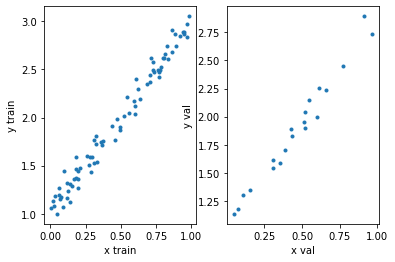

In [2]:
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(x_train, y_train, '.')
ax1.set_xlabel('x train')
ax1.set_ylabel('y train')

ax2.plot(x_val, y_val, '.')
ax2.set_xlabel('x val')
ax2.set_ylabel('y val')

We learned how to approximate the optimal parameters b=1 and m=2 using both gradient descent and linear regression:

In [3]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print('gradient descent', a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print('linear regression', linr.intercept_, linr.coef_[0])
print('true value: b=1 m=2')

gradient descent [1.02354094] [1.96896411]
linear regression [1.02354075] [1.96896447]
true value: b=1 m=2


Now, let's use PyTorch to do the same thing:

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# always initialize your random seed to ensure reproducibility of your results
torch.manual_seed(42)

# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
# print(a, b)

# Sets learning rate
lr = 1e-1

# Defines number of epochs
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

#An optimizer takes the parameters we want to update, the learning rate we want to use 
# (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    #calculate the loss
    loss = loss_fn(y_train_tensor, yhat)

    #Do you remember the starting point for computing the gradients? 
    # It was the loss, as we computed its partial derivatives w.r.t. our parameters. 
    # Hence, we need to invoke the backward() method from the corresponding Python variable
    loss.backward()    
    
    # performs the updates
    optimizer.step()
    
    #we also don’t need to zero the gradients one by one anymore. 
    # We just invoke the optimizer’s zero_grad() method and that’s it!
    optimizer.zero_grad()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Let's create a more general linear regression model and do a test/train split:

In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

# always initialize your random seed to ensure reproducibility of your results
np.random.seed(42)

#genenerate data for experiment
x = np.random.rand(100, 1)
true_a, true_b = 1, 2
y = true_a + true_b*x + 0.1*np.random.randn(100, 1)

# change they numpy arrays to tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

#  TensorDataset takes two tensors as arguments: one for the features, one for the labels. 
# For any given index, this will return the corresponding slice of each of those tensors.
dataset = TensorDataset(x_tensor, y_tensor) 

# test/train split
train_dataset, val_dataset = random_split(dataset, [80, 20])

# For large datasets, we will not be able to take the whole batch at each step
# Thus, we need mini-batches. This will slice our dataset accordingly.
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

# Our linear regression model
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Make a function that takes a model, a loss function, and an optimizer
# and returns another function that performs a training step, 
# taking a set of features and labels as arguments and returning the corresponding loss.
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

# Estimate a and b
torch.manual_seed(42)

# Send your tensor to whatever device you specify, including your GPU (referred to as cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Let's run our model!
model = ManualLinearRegression().to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-1)
train_step = make_train_step(model, loss_fn, optimizer)

n_epochs = 50
training_losses = []
validation_losses = []
print('initial state', model.state_dict())

for epoch in range(n_epochs):
    batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        batch_losses.append(loss)
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")

print(model.state_dict())

initial state OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])
[1] Training loss: 0.345	 Validation loss: 0.085
[2] Training loss: 0.081	 Validation loss: 0.047
[3] Training loss: 0.059	 Validation loss: 0.039
[4] Training loss: 0.052	 Validation loss: 0.034
[5] Training loss: 0.046	 Validation loss: 0.030
[6] Training loss: 0.041	 Validation loss: 0.026
[7] Training loss: 0.037	 Validation loss: 0.023
[8] Training loss: 0.033	 Validation loss: 0.020
[9] Training loss: 0.030	 Validation loss: 0.017
[10] Training loss: 0.027	 Validation loss: 0.015
[11] Training loss: 0.025	 Validation loss: 0.014
[12] Training loss: 0.023	 Validation loss: 0.012
[13] Training loss: 0.021	 Validation loss: 0.011
[14] Training loss: 0.019	 Validation loss: 0.010
[15] Training loss: 0.018	 Validation loss: 0.009
[16] Training loss: 0.017	 Validation loss: 0.008
[17] Training loss: 0.016	 Validation loss: 0.007
[18] Training loss: 0.015	 Validation loss: 0.007
[19] Tr

### Sequential models
Our model was simple enough… You may be thinking: “why even bother to build a class for it?!” Well, you have a point…

For straightforward models, that use run-of-the-mill layers, where the output of a layer is sequentially fed as an input to the next, we can use a, er… Sequential model :-)

In our case, we would build a Sequential model with a single argument, that is, the Linear layer we used to train our linear regression. The model would look like this:

```
model = nn.Sequential(nn.Linear(1, 1)).to(device)
```

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

# always initialize your random seed to ensure reproducibility of your results
np.random.seed(42)

#genenerate data for experiment
x = np.random.rand(100, 1)
true_a, true_b = 1, 2
y = true_a + true_b*x + 0.1*np.random.randn(100, 1)

# change they numpy arrays to tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

#  TensorDataset takes two tensors as arguments: one for the features, one for the labels. 
# For any given index, this will return the corresponding slice of each of those tensors.
dataset = TensorDataset(x_tensor, y_tensor) 

# test/train split
train_dataset, val_dataset = random_split(dataset, [80, 20])

# For large datasets, we will not be able to take the whole batch at each step
# Thus, we need mini-batches. This will slice our dataset accordingly.
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

# Make a function that takes a model, a loss function, and an optimizer
# and returns another function that performs a training step, 
# taking a set of features and labels as arguments and returning the corresponding loss.
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

# Estimate a and b
torch.manual_seed(42)

# Send your tensor to whatever device you specify, including your GPU (referred to as cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Let's run our model!
model = nn.Sequential(nn.Linear(1, 1)).to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-1)
train_step = make_train_step(model, loss_fn, optimizer)

n_epochs = 50
training_losses = []
validation_losses = []
print('initial state', model.state_dict())

for epoch in range(n_epochs):
    batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        batch_losses.append(loss)
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")

print(model.state_dict())

initial state OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])
[1] Training loss: 0.319	 Validation loss: 0.231
[2] Training loss: 0.081	 Validation loss: 0.123
[3] Training loss: 0.056	 Validation loss: 0.096
[4] Training loss: 0.048	 Validation loss: 0.083
[5] Training loss: 0.042	 Validation loss: 0.074
[6] Training loss: 0.038	 Validation loss: 0.067
[7] Training loss: 0.034	 Validation loss: 0.061
[8] Training loss: 0.030	 Validation loss: 0.056
[9] Training loss: 0.027	 Validation loss: 0.051
[10] Training loss: 0.025	 Validation loss: 0.047
[11] Training loss: 0.022	 Validation loss: 0.043
[12] Training loss: 0.021	 Validation loss: 0.040
[13] Training loss: 0.019	 Validation loss: 0.037
[14] Training loss: 0.017	 Validation loss: 0.034
[15] Training loss: 0.016	 Validation loss: 0.032
[16] Training loss: 0.015	 Validation loss: 0.030
[17] Training loss: 0.014	 Validation loss: 0.028
[18] Training loss: 0.013	 Validation loss: 0.027
[19] Training los

### More PyTorch Details

Sources: 

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

https://www.analyticsvidhya.com/blog/2018/02/pytorch-tutorial/

### Tensors
Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

To construct a matrix filled zeros and of dtype long:

x = torch.zeros(5, 3, dtype=torch.long)
print(x)

To construct a randomly initialized matrix:

In [7]:
x = torch.rand(5, 3)
print(x)

tensor([[0.9211, 0.6948, 0.4751],
        [0.1985, 0.1941, 0.0521],
        [0.3370, 0.6689, 0.8188],
        [0.7308, 0.0580, 0.1993],
        [0.4211, 0.9837, 0.5723]])


To construct a tensor directly from data:

In [8]:
x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


To get the size of the tensor:

In [9]:
print(x.size())

torch.Size([2])


### Operations
To add two tensors:

In [10]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)
print(x + y)

tensor([[1.1106, 1.6276, 1.0715],
        [0.8029, 1.3600, 0.3924],
        [0.4714, 0.0349, 1.5393],
        [1.1333, 1.0816, 0.3636],
        [0.4154, 0.2420, 1.0461]])


You can also add tensors this way:

In [11]:
print(torch.add(x, y))

tensor([[1.1106, 1.6276, 1.0715],
        [0.8029, 1.3600, 0.3924],
        [0.4714, 0.0349, 1.5393],
        [1.1333, 1.0816, 0.3636],
        [0.4154, 0.2420, 1.0461]])


We can also provide an output tensor as argument:

In [12]:
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

tensor([[1.1106, 1.6276, 1.0715],
        [0.8029, 1.3600, 0.3924],
        [0.4714, 0.0349, 1.5393],
        [1.1333, 1.0816, 0.3636],
        [0.4154, 0.2420, 1.0461]])


Or you can add in-place:

In [13]:
y.add_(x)
print(y)

tensor([[1.1106, 1.6276, 1.0715],
        [0.8029, 1.3600, 0.3924],
        [0.4714, 0.0349, 1.5393],
        [1.1333, 1.0816, 0.3636],
        [0.4154, 0.2420, 1.0461]])


You can use standard NumPy-like indexing with all bells and whistles!

In [14]:
print(x[:, 1])

tensor([0.7069, 0.8649, 0.0026, 0.6822, 0.0939])


If you want to resize/reshape tensor, you can use torch.view:

In [15]:
x = torch.randn(4, 4)
y = x.view(16)
print(x.size(), y.size())

torch.Size([4, 4]) torch.Size([16])


If you have a one element tensor, use .item() to get the value as a Python number:

In [16]:
x = torch.randn(1)
print(x)
print(x.item())

tensor([1.3018])
1.3017932176589966


### NumPy bridge:

Converting a Torch Tensor to a NumPy array and vice versa is a breeze.

The Torch Tensor and NumPy array will share their underlying memory locations (if the Torch Tensor is on CPU), and changing one will change the other. To change from tensor to numpy:

In [17]:
a = torch.ones(5)
print(a)

b = a.numpy()
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


See how the numpy array changed in value:

In [18]:
a.add_(1)
print(a)
print(b)

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


To change from numpy to tensor:

In [19]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


### Gradients

PyTorch uses a technique called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). That is, we have a recorder that records what operations we have performed, and then it replays it backward to compute our gradients. This technique is especially powerful when building neural networks, as we save time on one epoch by calculating differentiation of the parameters at the forward pass itself.

You will see this come up in code such as the following:

```
from torch.autograd import Variable

x = Variable(train_x)
y = Variable(train_y, requires_grad=False)
```

Here is a more concrete example. First, create x:

In [20]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Then, do more operations to it:

In [21]:
y = x + 2
print(y)

z = y * y * 3

print(z)
out = z.mean()

print(out)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


Meaning, the out tensor $o$ is given by: $o=\frac{1}{4}\Sigma_{i=1}^4 z_i = \frac{3(x_i+2)^2}{4}$, since we started with all terms equal to $x_i=1$, multiplied by itself, then multiplied by 3, and then took the mean by adding the four terms and dividing by 4. Taking the partial derivative, $\frac{d o} {d x_i}|_{x_i=1} = \frac{3}{2}(x_i+2)|_{x_i=1}  = 4.5$. How can we recover this? Using back propogation:

In [22]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


## Neural Networks

Neural networks can be constructed using the torch.nn package.

Now that you had a glimpse of autograd, nn depends on autograd to define models and differentiate them. An nn.Module contains layers, and a method forward(input)that returns the output.

For example, look at this network that classifies digit images:

<img src="images/mnist.png" width=700>

PyTorch autograd makes it easy to define computational graphs and take gradients, but raw autograd can be a bit too low-level for defining complex neural networks. This is where the nn module can help.

The nn package defines a set of modules, which we can think of as a neural network layer that produces output from input and may have some trainable weights.

It is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:

-Define the neural network that has some learnable parameters (or weights)

-Iterate over a dataset of inputs

-Process input through the network

-Compute the loss (how far is the output from being correct)

-Propagate gradients back into the network’s parameters

-Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

### TRAINING A CLASSIFIER

Let's use neural networks to classify images.

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

-For images, packages such as Pillow, OpenCV are useful

-For audio, packages such as scipy and librosa

-For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src="images/cifar10.png" width=700>


We will do the following steps in order:

-Load and normalizing the CIFAR10 training and test datasets using torchvision

-Define a Convolutional Neural Network

-Define a loss function

-Train the network on the training data

-Test the network on the test data

Using torchvision, it’s extremely easy to load CIFAR10:

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

Note: If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0.

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

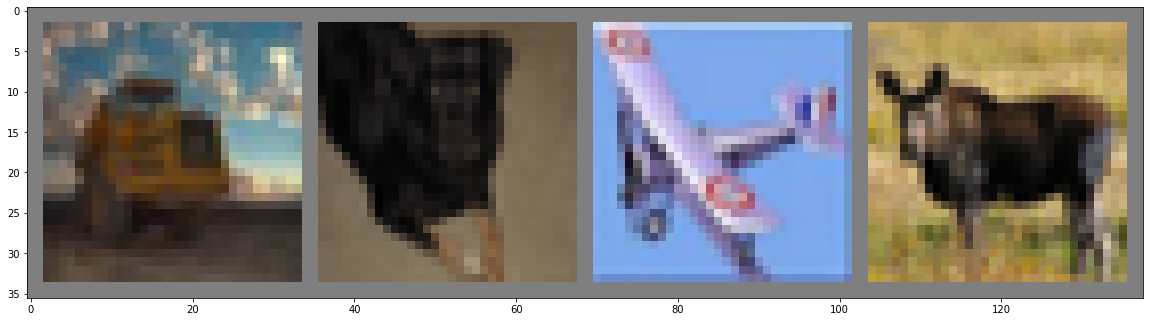

truck   dog plane  deer


In [25]:
# functions to show an image
def imshow(img):
    
    plt.figure(figsize=(20,10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Defining a convolutional neural network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.228
[1,  4000] loss: 1.862
[1,  6000] loss: 1.670
[1,  8000] loss: 1.579
[1, 10000] loss: 1.540
[1, 12000] loss: 1.457
[2,  2000] loss: 1.412
[2,  4000] loss: 1.391
[2,  6000] loss: 1.370
[2,  8000] loss: 1.325
[2, 10000] loss: 1.312
[2, 12000] loss: 1.306
Finished Training


### Save the model
You'll want to save the model so that you don't need to retrain it every time:

In [29]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

To load it back in, you can type:

In [30]:
PATH = './cifar_net.pth'
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

<Figure size 1440x720 with 0 Axes>

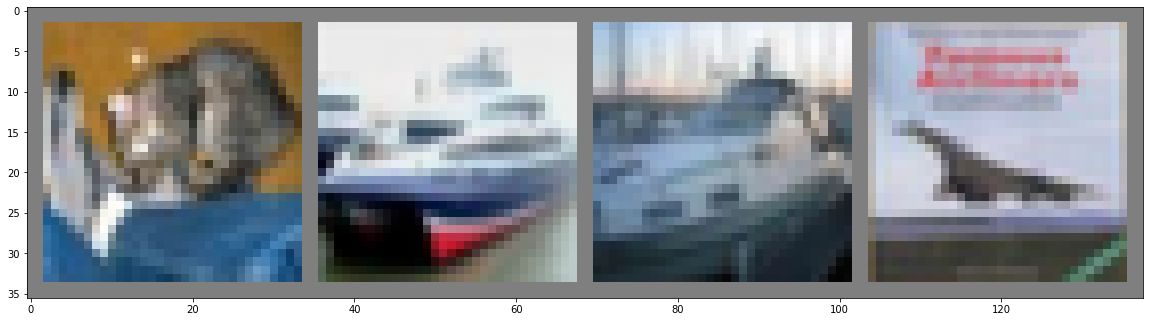

GroundTruth:    cat  ship  ship plane


In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images

plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [32]:
outputs = model(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [33]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 69 %
Accuracy of  bird : 56 %
Accuracy of   cat : 47 %
Accuracy of  deer : 25 %
Accuracy of   dog : 35 %
Accuracy of  frog : 73 %
Accuracy of horse : 48 %
Accuracy of  ship : 70 %
Accuracy of truck : 47 %


### Where do you go from here???

You are probably still **very** confused.

EXCELLENT 3blue1brown video: https://www.youtube.com/watch?v=aircAruvnKk

EXCELLENT FREE tutorial series that uses PyTorch written by Rachel Thomas who I went to grad school with and her husband who was president of Kaggle :)

https://course.fast.ai/

Andrew Ng's series: https://www.coursera.org/learn/neural-networks-deep-learning